In [1]:
#Michael Lust 
#Mujeeb Quadri 
#Mubeen Quadrt 
#Chase Spoerer 
#ECGR-4115 
#Convex Final Project
#December 14, 2021

# Imports
import math
import random
import pandas as pd
from heapq import heapify, heappush, heappop # This is for the min heap
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np # probably not necessary, but is used for initializing the edge and weights
import sys # used for setting the costs to inf (could be replaced with just using a really large number)
import time # used to get the runtime of the algorithm
from matplotlib import pyplot as plt # used to graph the path taken
import cvxpy as cp #CVX program

In [2]:
# Set up variables for DataCenter
numNodes = 18
edgeMatrix = np.zeros(shape = [numNodes, numNodes], dtype = int)
weightMatrix = np.zeros(shape = [numNodes, numNodes], dtype = float)
nodes = []
nodeCounter = 0
nodeCost = []
explored = [False] * numNodes
openList = []

In [3]:
#Mapping Node to reallocate the workload to other nodes
mappingNode = {
    "MappingNode1": [18, 12],
    "MappingNode2": [10, 12],
    "MappingNode3": [1, 12]
}

In [4]:
# defines coordinates of each data center as a big node (K=4)
dataCenter = {
    "DataCenter1": [18, 25],
    "DataCenter2": [10, 25],
    "DataCenter3": [1, 25], 
}


In [5]:
smallNode = {
    "Node1": [25, 25],
    "Node2": [23, 25],
    "Node3": [21, 25],
    "Node4": [19, 25],
    "Node5": [17, 25],
    "Node6": [15, 25],
    "Node7": [13, 25],
    "Node8": [11, 25],
    "Node9": [9, 25],
    "Node10": [7, 25],
    "Node11": [5, 25],
    "Node12": [2, 25]
}

In [6]:
# Node class
class Node(): # defining nodes
    nodeID = -1
    xCoord = 0
    yCoord = 0
    weight = 0
    prevNode = None
    isDataCenter = False
    isDataCenter1 = False 
    isDataCenter2 = False
    isDataCenter3 = False
    isMappingNode = False
    isCost = False
    
    # instantiate a node with given coordinates
    def __init__ (self, xCoord, yCoord, weight):
        global nodeCounter
        self.xCoord = xCoord
        self.yCoord = yCoord
        self.weight = weight
        self.nodeID = nodeCounter
        nodeCounter += 1
    
    # used for less than comparisons (min heap)
    def __lt__(self, other):
        global nodeCost
        if nodeCost[self.nodeID] < nodeCost[other.nodeID]:
            return True
        else:
            return False
        
    # keep track of what node you came from
    def setPrevNode(self, node):
        self.prevNode = node
        
    # set as MappingNode to be used and plotted.
    def setMappingNode(self):
        self.isMappingNode = True
    
    # set as DataCenter to be plotted.
    def setDataCenter(self):
        self.isDataCenter = True
    
    # set as DataCenter to be used.
    def setDataCenter1(self):
        self.isDataCenter1 = True

    # set as DataCenter to be used.
    def setDataCenter2(self):
        self.isDataCenter2 = True
        
    # set as DataCenter to be used.
    def setDataCenter3(self):
        self.isDataCenter3 = True
        
    def setCost(self):
        self.isCost = True
        
    # set as smaller nodes to be use
    #def setSmallNode(self):
        #self.isSmallNode = True


In [7]:
# defining the dataCenter workload from each mappingNode
#This can be thought as Cost from external source being fed into mappingNode
def workLoad():
    weight_cost = np.random.randint(low = 0 , high = 500, size=(12,)) 
    return weight_cost

In [8]:
#Testing a different workLoad function to best be compatable with CVXPY. The new version multiplies matrixes differently.
def workLoad2():
    power = np.random.randint(low = 0 , high = 5, size=(3,)) 
    bandwidth = np.random.randint(low = 0, high = 50, size = (3,3))
    x = np.random.randint(low = 0, high = 50, size = (3,3))
    y =  np.random.randint(low = 0 , high = 5, size=(3,)) 

    power = sum(power)
    bandwidth = sum(sum(bandwidth))
    left = power * (pow((y),2))
    right = bandwidth * (pow((y),2))
    work_load = left + right
    return work_load

In [9]:
test = workLoad2()
test

array([2106,  936, 3744], dtype=int32)

In [10]:
# defining the dataCenter cost from each node
def minCost(X,Y): #Cost function to minimize
    power = np.random.randint(low = 0 , high = 5, size=(3,)) 
    bandwidth = np.random.randint(low = 0, high = 50, size = (3,3))

    for i in range(2):
        for j in range(2):
            power[i] = power[i] * (pow((Y[i]),2))
            bandwidth[i][j] = bandwidth[i][j] * (pow((X[i][j]),2))
    bandwidth = sum(bandwidth)
    total = power + bandwidth #Minimize total
    total = sum(total)
    return total

In [11]:
#Testing minCost function
x = np.random.randint(low = 0 , high = 5, size=(3,3)) 
y = np.random.randint(low = 0, high = 50, size = (3))
test = minCost(x,y)
test

475468

In [12]:
def powerCost(Y):
    for i in range(2):
        power[i] = power[i] * (pow((Y[i]),2))
    return power

In [13]:
def bandwidthCost(X):
    for i in range(2):
        for j in range(2):
            bandwidth[i][j] = bandwidth[i][j] * (pow((X[i][j]),2))
    return bandwidth

In [14]:
nodeCost = workLoad()
nodeCost

array([435, 371, 496,   4, 231, 112, 137, 254, 454, 252,  52, 419])

In [15]:
zeroMatrix = np.zeros(6)

In [16]:
nodeCost = np.concatenate((nodeCost,zeroMatrix), axis = None)
nodeCost

array([435., 371., 496.,   4., 231., 112., 137., 254., 454., 252.,  52.,
       419.,   0.,   0.,   0.,   0.,   0.,   0.])

In [17]:
#Setting up the parameters to be added to the node class
node1 = (Node(smallNode['Node1'][0],smallNode['Node1'][1],nodeCost[0]))
node1.setDataCenter1()

node2 = (Node(smallNode['Node2'][0],smallNode['Node2'][1],nodeCost[1]))
node2.setDataCenter1()

node3 = (Node(smallNode['Node3'][0],smallNode['Node3'][1],nodeCost[2]))
node3.setDataCenter1()

node4 = (Node(smallNode['Node4'][0],smallNode['Node4'][1],nodeCost[3]))
node4.setDataCenter1()

node5 = (Node(smallNode['Node5'][0],smallNode['Node5'][1],nodeCost[4]))
node5.setDataCenter2()

node6 = (Node(smallNode['Node6'][0],smallNode['Node6'][1],nodeCost[5]))
node6.setDataCenter2()

node7 = (Node(smallNode['Node7'][0],smallNode['Node7'][1],nodeCost[6]))
node7.setDataCenter2()

node8 = (Node(smallNode['Node8'][0],smallNode['Node8'][1],nodeCost[7]))
node8.setDataCenter2()

node9 = (Node(smallNode['Node9'][0],smallNode['Node9'][1],nodeCost[8]))
node9.setDataCenter3()

node10 = (Node(smallNode['Node10'][0],smallNode['Node10'][1],nodeCost[9]))
node10.setDataCenter3()

node11 = (Node(smallNode['Node11'][0],smallNode['Node11'][1],nodeCost[10]))
node11.setDataCenter3()

node12 = (Node(smallNode['Node12'][0],smallNode['Node12'][1],nodeCost[11]))
node12.setDataCenter3()

mappingNode1 = (Node(mappingNode['MappingNode1'][0],mappingNode['MappingNode1'][1],nodeCost[12]))
mappingNode1.setMappingNode()

mappingNode2 = (Node(mappingNode['MappingNode2'][0],mappingNode['MappingNode2'][1],nodeCost[13]))
mappingNode2.setMappingNode()

mappingNode3 = (Node(mappingNode['MappingNode3'][0],mappingNode['MappingNode3'][1],nodeCost[14]))
mappingNode3.setMappingNode()

dataCenter1 = (Node(dataCenter['DataCenter1'][0],dataCenter['DataCenter1'][1],nodeCost[15]))
dataCenter1.setDataCenter()

dataCenter2 = (Node(dataCenter['DataCenter2'][0],dataCenter['DataCenter2'][1],nodeCost[16]))
dataCenter2.setDataCenter()

dataCenter3 = (Node(dataCenter['DataCenter3'][0],dataCenter['DataCenter3'][1],nodeCost[17]))
dataCenter3.setDataCenter()

In [18]:
#Adding the parameters of xCoord, yCoord, and weight to the node class
nodes.append(node1)
nodes.append(node2)
nodes.append(node3)
nodes.append(node4)
nodes.append(node5)
nodes.append(node6)
nodes.append(node7)
nodes.append(node8)
nodes.append(node9)
nodes.append(node10)
nodes.append(node11)
nodes.append(node12)
nodes.append(mappingNode1)
nodes.append(mappingNode2)
nodes.append(mappingNode3)
nodes.append(dataCenter1)
nodes.append(dataCenter2)
nodes.append(dataCenter3)
nodes

In [19]:
#Appending the total weights from each node in each dataCenter.
cost_DC1 = 0
cost_DC2 = 0
cost_DC3 = 0

for i in range (numNodes):
    if nodes[i].isDataCenter1:
        cost_DC1 += nodes[i].weight

for i in range (numNodes):
    if nodes[i].isDataCenter2:
        cost_DC2 += nodes[i].weight

for i in range (numNodes):
    if nodes[i].isDataCenter3:
        cost_DC3 += nodes[i].weight

print(cost_DC1)
print(cost_DC2)
print(cost_DC3)

1306.0
734.0
1177.0


In [20]:
#Updating the cost C of each dataCenter when allocating workload.
def newCost():
    updatedCost = workLoad()
    newDataCenter1 = updatedCost[0] + updatedCost[1] + updatedCost[2] + updatedCost[3]
    newDataCenter2 = updatedCost[4] + updatedCost[5] + updatedCost[6] + updatedCost[7]
    newDataCenter3 = updatedCost[8] + updatedCost[9] + updatedCost[10] + updatedCost[11]
    updatedCost = [newDataCenter1, newDataCenter2, newDataCenter3]
    return updatedCost

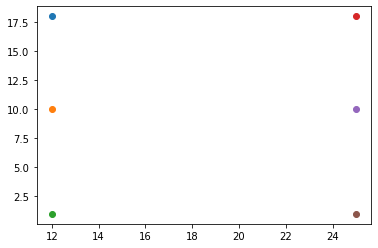

In [21]:
#Showing a simple graph of the nodes being able to be plotted
for i in range(numNodes):
    if nodes[i].isDataCenter or nodes[i].isMappingNode:
        plt.plot(nodes[i].yCoord, nodes[i].xCoord, marker = "o") 

In [22]:
node_direction = [1,-1]
A = random.choice(node_direction)
A

-1

In [23]:
b = ([nodes[15].weight,nodes[16].weight,nodes[17].weight])
b 

[0.0, 0.0, 0.0]

In [24]:
Cost_T0 = ([cost_DC1, cost_DC2, cost_DC3])
Cost_T0

[1306.0, 734.0, 1177.0]

In [25]:
#Testing convering minimization problem to scalar
def costFunction(X,Y):
    power = np.random.randint(low = 0 , high = 5, size=(3,)) 
    bandwidth = np.random.randint(low = 0, high = 50, size = (3,3))
    
    power = sum(power)
    bandwidth = sum(sum(bandwidth))
    pow_sum = sum(power * (pow((Y),2)))
    band_sum = sum(bandwidth * (pow((X),2)))
    all_sum = pow_sum + band_sum
    total = sum(all_sum)
    return total

In [26]:
#Testig costFunction to see what values are likely
x = np.random.randint(low = 0 , high = 5, size=(3,3)) 
y = np.random.randint(low = 0, high = 50, size = (3))
totally = costFunction(x,y)
totally

86861

In [27]:
#Algorithm to allocate resources given cost function
def resourceAllocate_1(dataCenterCost):
    #Use of Linear Programming to minimize the cost for resource allocation
    #Using CVX in Python
    
    #node_direction = [-1,1]
    node_direction = [-1]
    #We are keeping the workload as always sending to not back up the network; nodes on receiving 
    #workload continuously at random will increase conjestion and optimization will be impossible
    workload_treated = [-1,1] #Workload is shown as treated always so it is not used
    A = random.choice(node_direction) #Connection entering or leaving node
    b = np.zeros(len(dataCenterCost))
    
    for i in range (len(dataCenterCost)):
        b[i] = nodes[i + 12].weight + dataCenterCost[i] #exogenous workload to be reallocated
    
    # Construct the problem.
    x = cp.Variable((len(b),len(b)), PSD=True) # Creates a 3 by 3 positive semidefinite variable.
    y = cp.Variable(len(b))
    
    #Now doing the CVX minimization
    #objective = cp.Minimize(sum(power * (pow((y),2))) + sum(sum(bandwidth * (pow((x),2)))))
    #objective = cp.Minimize(sum(power * (pow((y),2)) + bandwidth * (pow((x),2))))
    objective = cp.Minimize(costFunction(x,y))
    #constraints = [0 <= x, x <= 1]
    constraints = [x[0][0] + x[1][0] + x[2][0] == y[0],
                   x[0][1] + x[1][1] + x[2][1] == y[1],
                   x[0][0] + x[1][0] + x[2][0] == y[2],
                   
                   b[0] == x[0][0] + x[0][1] + x[0][2],
                   b[1] == x[1][0] + x[1][1] + x[1][2],
                   b[2] == x[2][0] + x[2][1] + x[2][2]]
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Print result.
    #print("\nThe optimal value is", prob.value) #CVX is having issues solving this. It is just the sum of the 
                                                 # Y matrix. I tried a full day to solve but to no avail.
    print("This is for problem 1")
    print("A solution x is")
    print(x.value) 
    print("A solution y is")
    print(y.value)
    return prob.value, x.value, y.value

In [28]:
#Algorithm to allocate resources given cost function with updated parameters
def resourceAllocate_2(dataCenterCost):
    #Use of Linear Programming to minimize the cost for resource allocation
    #Using CVX in Python
    
    node_direction = [-1,1]
    workload_treated = [-1]
    A = random.choice(node_direction) #Connection entering or leaving node
    Y_direction = random.choice(workload_treated) 
    b = np.zeros(len(dataCenterCost))
    x_max = np.zeros(len(dataCenterCost))
    y_untreated = np.zeros(len(dataCenterCost)) #This is a y matrix that represents no workload has been treated.
    
    for i in range (len(dataCenterCost)):
        b[i] = nodes[i + 12].weight + dataCenterCost[i] #exogenous workload to be reallocated
    
    # Construct the problem.
    x = cp.Variable((len(b),len(b)), PSD=True) # Creates a 3 by 3 positive semidefinite variable.
    y = cp.Variable(len(b))
    #objective = cp.Minimize(cp.sum(calculate_scalar(K_Data_Center_Predict, Mapping_Nodes_J, theta)))
    
    #Now doing CVX minimization
    #objective = cp.Minimize(sum(power * (pow((y),2))) + sum(sum(bandwidth * (pow((x),2)))))
    #objective = cp.Minimize(sum(power * (pow((y),2)) + bandwidth * (pow((x),2))))
    objective = cp.Minimize(costFunction(x,y))
    
    for i in range((len(b))):
        if x_max[i] < b[i]:
            x_max[i] = b[i] 
            
    constraints = [x[0][0] + x[1][0] + x[2][0] == y[0],
                   x[0][1] + x[1][1] + x[2][1] == y[1],
                   x[0][0] + x[1][0] + x[2][0] == y[2],
                   
                   b[0] == x[0][0] + x[0][1] + x[0][2],
                   b[1] == x[1][0] + x[1][1] + x[1][2],
                   b[2] == x[2][0] + x[2][1] + x[2][2]]
    
    
    prob = cp.Problem(objective, constraints)
    
    if A < 0: #If the link is sending
        prob.solve()

        # Print result.
        #print("\nThe optimal value is", prob.value)
        print("This is for problem 2")
        print("A solution x is")
        print(x.value)
        print("A solution y is")
        print(y.value)
        
        for i in range(len(b)):
            for j in range(len(b)):
                nodes[i + 12].weight = b[i] + nodes[i + 12].weight #b[i] queues workload into mapping nodes, adds leftovers
                if x[i][j].value == None:
                    x.value = np.zeros((3,3))
                b[i] = b[i] - x[i][j].value #Workload is scheduled into x[i] to take away from mapping nodes, b[i] is leftovers
                if b[i] <= 0: #If the workload taken off is more than in the queue, the queue will be set to zero instead of
                    b[i] = 0  #going into the negatives.
                nodes[i + 15].weight = x[i][j].value + nodes[i + 15].weight #dataCenter Nodes receives weights distributed by CVX optimization
                nodes[i + 12].weight = b[i] #Mapping node is updated by any left over b[i]
                if Y_direction <= 0: #If y < 0: The workload is counted as treated and weights reset. If not, they are left queued.
                    nodes[i + 15].weight = 0 
                    nodes[i + 12].weight = 0
            
    elif A > 0: #If the link is receiving 
        node_weight = []
        added_weight = 0
        for i in range(len(b)): 
            nodes[i + 12].weight = nodes[i + 12].weight + b[i] #Workload scheduled is added to the queue for mappingData
            added_weight = nodes[12].weight + nodes[13].weight + nodes[14].weight
            node_weight.append(nodes[12].weight)
            node_weight.append(nodes[13].weight)
            node_weight.append(nodes[14].weight)
            return added_weight, node_weight, y_untreated #Returns the untreated workload split since it is ingoing.
    return prob.value, x.value, y.value #If link was sending, then return optimization values

In [29]:
def calculate_scalar(X, Y, theta, M): #Declaring values and computing the Scalar value J
#loss is calculated by taking the mean of squared differences between actual(target) and predicted values. 
    predictions = X.dot(theta)  #Dot product of array X and theta
    errors = np.subtract(predictions,Y) #Matrix subtraction with predictions and Y
    squaringErrors = np.square(errors) #Now errors contained in matrix. We square all values in matrix error.
    J = 1/(2*M)*np.sum(squaringErrors) #Scalar equation using matrix squErrors
    return J

In [30]:
def gradient_descent(X, Y, theta, alpha, iterations, M):  #Function to calculate gradient descent for linear regression
    
    result = np.zeros(iterations)   #creating a row of an array with an undetermined amount of zeroes.
    theta_interval = np.zeros([iterations, theta.size])  #creating an array for each interval to be plotted (X1, X2, X3) 
    
    for i in range(iterations):    #For loop with iterations as an input.
        predictions = X.dot(theta)   #Dot product of array X and theta resulting in scalar
        errors = np.subtract(predictions,Y) #Matrix subtration between predictions and value Y
        sum_delta = (alpha/M)*X.transpose().dot(errors); #learning rate over training examples * scalar of resulting dot product.  
        theta = theta-sum_delta;   #Current theta minus scalar sum_delta for final value of theta                      
        result[i] = calculate_scalar(X, Y, theta, M)
        theta_interval[i] = theta #Needed to show the previous thetas used for the resulting scalar.

    return theta, result, theta_interval

In [31]:
#Running the algorithm with input of time_slot
time_slot = 100

X_1 = np.zeros(time_slot)
X_val_1 = np.zeros((time_slot,3,3))

X_2 = np.zeros(time_slot)
X_val_2 = np.zeros((time_slot,3,3))

Y_1 = np.zeros((time_slot,3))
Y_2 = np.zeros((time_slot,3))

for i in range(time_slot):
    Cost_T_1 = newCost()
    X_1[i], X_val_1[i], Y_1[i] = resourceAllocate_1(Cost_T_1)
    i += 1
    
for j in range(time_slot):
    Cost_T_2 = newCost()
    X_2[j], X_val_2[j], Y_2[j] = resourceAllocate_2(Cost_T_2)
    j += 1

This is for problem 1
A solution x is
[[467.20194918 153.8236963  379.86847676]
 [153.8236963   86.1808716  155.73172163]
 [379.86847676 155.73172163 337.71390818]]
A solution y is
[1000.94646059  395.72787677 1000.94656954]


G:\Machine_Learning\lib\site-packages\cvxpy\problems\problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


This is for problem 1
A solution x is
[[689.57065413 598.76978765 241.03153602]
 [598.76978765 531.59293189 230.06201842]
 [241.03153602 230.06201842 154.84394248]]
A solution y is
[1529.48132469 1360.53814196 1529.46673573]
This is for problem 1
A solution x is
[[410.11995022 296.06068094 421.64743446]
 [296.06068094 217.78651466 315.11149818]
 [421.64743446 315.11149818 454.33063351]]
A solution y is
[1127.65935485  828.96051296 1128.0459955 ]
This is for problem 1
A solution x is
[[ 271.21167171  534.30483399  158.24955863]
 [ 534.30483399 1080.97917515  280.38541411]
 [ 158.24955863  280.38541411  139.33818147]]
A solution y is
[ 963.82506659 1895.73762294  963.82506659]
This is for problem 1
A solution x is
[[ 47.97520321 171.31946404 175.10167643]
 [171.31946404 596.92208457 608.47456691]
 [175.10167643 608.47456691 621.47763016]]
A solution y is
[ 394.39906141 1376.71864141  394.39906141]
This is for problem 1
A solution x is
[[1231.08916711  880.48340373  567.85109021]
 [ 880.4

In [32]:
print(len(X_1))
print(len(X_2))

100
100


In [33]:
print(X_val_1)
print(X_val_2)

[[[ 4.67201949e+02  1.53823696e+02  3.79868477e+02]
  [ 1.53823696e+02  8.61808716e+01  1.55731722e+02]
  [ 3.79868477e+02  1.55731722e+02  3.37713908e+02]]

 [[ 6.89570654e+02  5.98769788e+02  2.41031536e+02]
  [ 5.98769788e+02  5.31592932e+02  2.30062018e+02]
  [ 2.41031536e+02  2.30062018e+02  1.54843942e+02]]

 [[ 4.10119950e+02  2.96060681e+02  4.21647434e+02]
  [ 2.96060681e+02  2.17786515e+02  3.15111498e+02]
  [ 4.21647434e+02  3.15111498e+02  4.54330634e+02]]

 [[ 2.71211672e+02  5.34304834e+02  1.58249559e+02]
  [ 5.34304834e+02  1.08097918e+03  2.80385414e+02]
  [ 1.58249559e+02  2.80385414e+02  1.39338181e+02]]

 [[ 4.79752032e+01  1.71319464e+02  1.75101676e+02]
  [ 1.71319464e+02  5.96922085e+02  6.08474567e+02]
  [ 1.75101676e+02  6.08474567e+02  6.21477630e+02]]

 [[ 1.23108917e+03  8.80483404e+02  5.67851090e+02]
  [ 8.80483404e+02  6.56414340e+02  4.57374936e+02]
  [ 5.67851090e+02  4.57374936e+02  3.72826108e+02]]

 [[ 3.16404256e+02  3.50463487e+02  3.58810951e+02]


In [34]:
#Given Prob.value is not working properly, the X_1 and X_2 values are added manually
for i in range(len(X_1)):
    X_1[i] = sum(Y_1[i])
    
for i in range(len(X_2)):
    X_2[i] = sum(Y_2[i])
X_1

array([2397.6209069 , 4419.48620238, 3084.66586332, 3823.38775613,
       2165.51676423, 7353.65512077, 3195.36606162, 3958.60406164,
       4205.59685919, 2087.13974696, 5726.50513044, 5320.6311329 ,
       5436.82467332, 4903.18299359, 4418.29500105, 3889.25549121,
       6316.26407413, 2463.44861918, 2567.30943294, 3273.53626493,
       3704.92699216, 4742.72854164, 1636.1769838 , 3520.1994304 ,
       4266.64348832, 2236.51348442, 2590.78908841, 4684.06642932,
       3158.41722748, 5166.70049164, 2550.61669586, 2856.43677769,
       2371.11212287, 4289.00391905, 3218.33321151, 3380.17532482,
        391.88929616, 4417.93936166, 5118.74779882, 4345.12470371,
       3329.4367024 , 2672.50962653, 3389.37103623, 2340.43208888,
       2805.79685796, 3634.83245303, 2524.14201371, 4388.82236624,
       4251.12513438, 4051.70821943, 3982.05893393, 4840.48355956,
       2433.83131287, 2666.39297242, 3813.03609515, 2950.35561919,
       3497.61351079, 3654.91146076, 3285.3228116 , 3399.99371

The parameters of the line: [[-2.71265555e-03]
 [ 5.92116138e+01]]


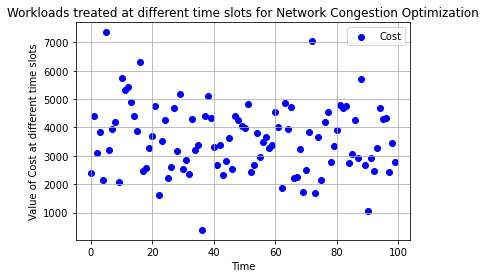

In [35]:
#Plotting the best fit line for Network Conjestion from Resource Allocation 1
ones_fit_1 = X_1.reshape(len(X_1),1)
X_fit_1 = np.append(ones_fit_1, np.ones((len(X_1),1)), axis = 1)
time_slot_fit_1 = np.arange(time_slot).reshape((time_slot, 1))

# Calculating the parameters using the least square method
theta_1 = np.linalg.inv(X_fit_1.T.dot(X_fit_1)).dot(X_fit_1.T).dot(time_slot_fit_1)

print(f'The parameters of the line: {theta_1}')

# Now, calculating the y-axis values against x-values according to
# the parameters theta0 and theta1

y_line_1 = X_fit_1.dot(theta_1)

plt.scatter(time_slot_fit_1, ones_fit_1, color = 'Blue', label = 'Cost' )
#plt.plot(y_line_1, X_fit_1, color = 'Red', label = 'BestFitLine') Best fit line was not showing properly
plt.rcParams["figure.figsize"] = (10,6)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Value of Cost at different time slots')
plt.title('Workloads treated at different time slots for Network Congestion Optimization')
#plt.xlim([1500, 5000]) #Gets rid of any outliers for second BestFitLine
#plt.ylim([10000,35000])
plt.legend()
plt.show()

The parameters of the line: [[nan]
 [nan]]


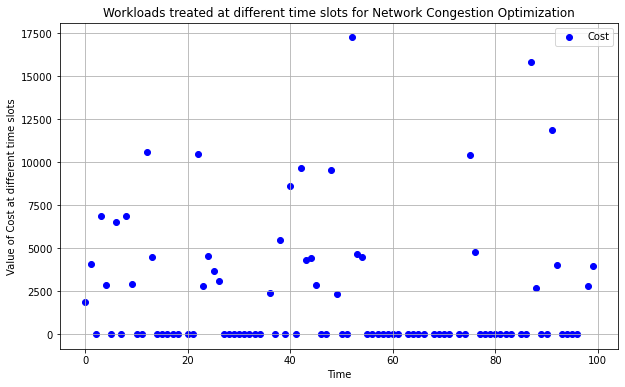

In [36]:
#Plotting the best fit line for Network Conjestion from Resource Allocation 1
ones_fit_2 = X_2.reshape(len(X_2),1)
X_fit_2 = np.append(ones_fit_2, np.ones((len(X_2),1)), axis = 1)
time_slot_fit_2 = np.arange(time_slot).reshape((time_slot, 1))

# Calculating the parameters using the least square method
theta_2 = np.linalg.inv(X_fit_2.T.dot(X_fit_2)).dot(X_fit_2.T).dot(time_slot_fit_2)

print(f'The parameters of the line: {theta_2}')

# Now, calculating the y-axis values against x-values according to
# the parameters theta0 and theta1

y_line_2 = X_fit_2.dot(theta_2)

plt.scatter(time_slot_fit_2, ones_fit_2, color = 'Blue', label = 'Cost' )
#plt.plot(y_line_2, X_fit_2, color = 'Red', label = 'BestFitLine') Best fit line was not showing properly
plt.rcParams["figure.figsize"] = (10,6)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Value of Cost at different time slots')
plt.title('Workloads treated at different time slots for Network Congestion Optimization')
#plt.xlim([1, 8500]) #Gets rid of any outliers for second BestFitLine
#plt.ylim([1, 100000])
plt.legend()
plt.show()

In [37]:
#Testing Gradient Descent for both Network ALlocation algorithms

In [38]:
#Allocating new arrays to represent optimization values to be tested.
X_val_1_DC1 = np.zeros((time_slot,3))
X_val_1_DC2 = np.zeros((time_slot,3))
X_val_1_DC3 = np.zeros((time_slot,3))

X_val_2_DC1 = np.zeros((time_slot,3))
X_val_2_DC2 = np.zeros((time_slot,3))
X_val_2_DC3 = np.zeros((time_slot,3))

for i in range(len(X_val_1)):
    for j in range(2):
        X_val_1_DC1[i][0] = X_val_1[i][j][0]
        X_val_1_DC2[i][1] = X_val_1[i][j][1]
        X_val_1_DC3[i][2] = X_val_1[i][j][2]  

for i in range(len(X_val_2)):
    for j in range(2):
        X_val_2_DC1[i][0] = X_val_2[i][j][0]
        X_val_2_DC2[i][1] = X_val_2[i][j][1]
        X_val_2_DC3[i][2] = X_val_2[i][j][2]


In [39]:
X_val_1_DC2

array([[   0.        ,   86.1808716 ,    0.        ],
       [   0.        ,  531.59293189,    0.        ],
       [   0.        ,  217.78651466,    0.        ],
       [   0.        , 1080.97917515,    0.        ],
       [   0.        ,  596.92208457,    0.        ],
       [   0.        ,  656.41434003,    0.        ],
       [   0.        ,  390.44708025,    0.        ],
       [   0.        ,  558.94850038,    0.        ],
       [   0.        ,  320.69235288,    0.        ],
       [   0.        ,  130.56787799,    0.        ],
       [   0.        ,  694.97014178,    0.        ],
       [   0.        ,  248.72388636,    0.        ],
       [   0.        ,  401.47065241,    0.        ],
       [   0.        ,  680.90746304,    0.        ],
       [   0.        ,  525.39381538,    0.        ],
       [   0.        , 1196.41158851,    0.        ],
       [   0.        ,  399.03691986,    0.        ],
       [   0.        ,  262.36254233,    0.        ],
       [   0.        ,  362.

In [40]:
np.delete(X_val_1_DC2,[0,2],1)

array([[  86.1808716 ],
       [ 531.59293189],
       [ 217.78651466],
       [1080.97917515],
       [ 596.92208457],
       [ 656.41434003],
       [ 390.44708025],
       [ 558.94850038],
       [ 320.69235288],
       [ 130.56787799],
       [ 694.97014178],
       [ 248.72388636],
       [ 401.47065241],
       [ 680.90746304],
       [ 525.39381538],
       [1196.41158851],
       [ 399.03691986],
       [ 262.36254233],
       [ 362.96216116],
       [ 521.2944411 ],
       [ 361.96932554],
       [ 590.49138786],
       [ 186.11481007],
       [ 347.12624222],
       [ 468.28047959],
       [ 394.56423292],
       [  81.16060036],
       [ 637.55517828],
       [  70.92601855],
       [ 841.44217265],
       [ 802.22817834],
       [ 548.76950917],
       [ 570.08585602],
       [ 311.85917307],
       [ 541.09889272],
       [ 283.94074208],
       [  21.22960568],
       [ 293.64122866],
       [ 492.7689633 ],
       [ 359.69269432],
       [ 822.37342346],
       [ 220.615

In [41]:
#Total workload that has been treated to be compared to the optimal solution value.
Y_1_row = np.array(Y_1)
Y_1 = Y_1_row.sum(axis = 1)
Y_1

array([2397.6209069 , 4419.48620238, 3084.66586332, 3823.38775613,
       2165.51676423, 7353.65512077, 3195.36606162, 3958.60406164,
       4205.59685919, 2087.13974696, 5726.50513044, 5320.6311329 ,
       5436.82467332, 4903.18299359, 4418.29500105, 3889.25549121,
       6316.26407413, 2463.44861918, 2567.30943294, 3273.53626493,
       3704.92699216, 4742.72854164, 1636.1769838 , 3520.1994304 ,
       4266.64348832, 2236.51348442, 2590.78908841, 4684.06642932,
       3158.41722748, 5166.70049164, 2550.61669586, 2856.43677769,
       2371.11212287, 4289.00391905, 3218.33321151, 3380.17532482,
        391.88929616, 4417.93936166, 5118.74779882, 4345.12470371,
       3329.4367024 , 2672.50962653, 3389.37103623, 2340.43208888,
       2805.79685796, 3634.83245303, 2524.14201371, 4388.82236624,
       4251.12513438, 4051.70821943, 3982.05893393, 4840.48355956,
       2433.83131287, 2666.39297242, 3813.03609515, 2950.35561919,
       3497.61351079, 3654.91146076, 3285.3228116 , 3399.99371

In [42]:
#Total workload that has been treated to be compared to the optimal solution value.
Y_2_row = np.array(Y_2)
Y_2 = Y_2_row.sum(axis = 1)
Y_2

array([ 1860.70183926,  4096.38400427,     0.        ,  6834.45485421,
        2872.82435713,     0.        ,  6504.29071374,     0.        ,
        6879.62273915,  2908.74438727,     0.        ,     0.        ,
       10606.09459815,  4495.76624231,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,            nan,
           0.        ,     0.        , 10442.46147574,  2774.82934103,
        4562.59240405,  3683.49800947,  3075.82108835,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,            nan,
        2359.66791956,     0.        ,  5466.95235942,     0.        ,
        8589.59057676,     0.        ,  9623.8274349 ,  4316.94316361,
        4430.99792197,  2865.20026834,     0.        ,     0.        ,
        9553.26079217,  2338.72395539,     0.        ,     0.        ,
       17242.22572602,  4641.85259399,  4497.51566734,     0.        ,
      

In [43]:
#Reshape is performed to run standard scaling so that gradient descent can be run.
M = time_slot
Y_T_1 = Y_1
Y_T_1 = Y_T_1.reshape(M,1)
Y_T_1

array([[2397.6209069 ],
       [4419.48620238],
       [3084.66586332],
       [3823.38775613],
       [2165.51676423],
       [7353.65512077],
       [3195.36606162],
       [3958.60406164],
       [4205.59685919],
       [2087.13974696],
       [5726.50513044],
       [5320.6311329 ],
       [5436.82467332],
       [4903.18299359],
       [4418.29500105],
       [3889.25549121],
       [6316.26407413],
       [2463.44861918],
       [2567.30943294],
       [3273.53626493],
       [3704.92699216],
       [4742.72854164],
       [1636.1769838 ],
       [3520.1994304 ],
       [4266.64348832],
       [2236.51348442],
       [2590.78908841],
       [4684.06642932],
       [3158.41722748],
       [5166.70049164],
       [2550.61669586],
       [2856.43677769],
       [2371.11212287],
       [4289.00391905],
       [3218.33321151],
       [3380.17532482],
       [ 391.88929616],
       [4417.93936166],
       [5118.74779882],
       [4345.12470371],
       [3329.4367024 ],
       [2672.509

In [45]:
#Reshape is performed to run standard scaling so that gradient descent can be run.
Y_T_2 = Y_2
Y_T_2 = Y_T_2.reshape(M,1)
Y_T_2[np.isnan(Y_T_2)] = 0
for i in range(len(Y_2)):
    if Y_T_2[i][0] <= 0:
        Y_T_2[i] = Y_T_2[i-1][0]
Y_T_2

array([[ 1860.70183926],
       [ 4096.38400427],
       [ 4096.38400427],
       [ 6834.45485421],
       [ 2872.82435713],
       [ 2872.82435713],
       [ 6504.29071374],
       [ 6504.29071374],
       [ 6879.62273915],
       [ 2908.74438727],
       [ 2908.74438727],
       [ 2908.74438727],
       [10606.09459815],
       [ 4495.76624231],
       [ 4495.76624231],
       [ 4495.76624231],
       [ 4495.76624231],
       [ 4495.76624231],
       [ 4495.76624231],
       [ 4495.76624231],
       [ 4495.76624231],
       [ 4495.76624231],
       [10442.46147574],
       [ 2774.82934103],
       [ 4562.59240405],
       [ 3683.49800947],
       [ 3075.82108835],
       [ 3075.82108835],
       [ 3075.82108835],
       [ 3075.82108835],
       [ 3075.82108835],
       [ 3075.82108835],
       [ 3075.82108835],
       [ 3075.82108835],
       [ 3075.82108835],
       [ 3075.82108835],
       [ 2359.66791956],
       [ 2359.66791956],
       [ 5466.95235942],
       [ 5466.95235942],


In [46]:
#Structuring the dataset to test linear regression
Ones_T = np.ones((M,1))

X_val_1_DC1 = np.delete(X_val_1_DC1,[1,2],1)
X_val_1_DC2 = np.delete(X_val_1_DC2,[0,2],1)
X_val_1_DC3 = np.delete(X_val_1_DC3,[0,1],1)


X_val_2_DC1 = np.delete(X_val_2_DC1,[1,2],1)
X_val_2_DC2 = np.delete(X_val_2_DC2,[0,2],1)
X_val_2_DC3 = np.delete(X_val_2_DC3,[0,1],1)


X_T_1 = np.hstack((Ones_T, X_val_1_DC1, X_val_1_DC2, X_val_1_DC3))
print(X_T_1)

X_T_2 = np.hstack((Ones_T, X_val_2_DC1, X_val_2_DC2, X_val_2_DC3))
print(X_T_2)


Y_T_1 = np.hstack((Ones_T,Y_T_1))
Y_T_2 = np.hstack((Ones_T,Y_T_2))

[[ 1.00000000e+00  1.53823696e+02  8.61808716e+01  1.55731722e+02]
 [ 1.00000000e+00  5.98769788e+02  5.31592932e+02  2.30062018e+02]
 [ 1.00000000e+00  2.96060681e+02  2.17786515e+02  3.15111498e+02]
 [ 1.00000000e+00  5.34304834e+02  1.08097918e+03  2.80385414e+02]
 [ 1.00000000e+00  1.71319464e+02  5.96922085e+02  6.08474567e+02]
 [ 1.00000000e+00  8.80483404e+02  6.56414340e+02  4.57374936e+02]
 [ 1.00000000e+00  3.50463487e+02  3.90447080e+02  4.03039544e+02]
 [ 1.00000000e+00  4.60151422e+02  5.58948500e+02  4.94208421e+02]
 [ 1.00000000e+00  1.45036120e+01  3.20692353e+02  1.09059249e+02]
 [ 1.00000000e+00  2.26204663e+02  1.30567878e+02  1.10104850e+02]
 [ 1.00000000e+00  7.55660821e+02  6.94970142e+02  3.56962435e+02]
 [ 1.00000000e+00  3.02433404e+02  2.48723886e+02  7.83332728e+01]
 [ 1.00000000e+00  6.40072559e+02  4.01470652e+02  2.23119312e+02]
 [ 1.00000000e+00  6.11392318e+02  6.80907463e+02  4.70290815e+02]
 [ 1.00000000e+00  5.74168856e+02  5.25393815e+02  2.89872845e

In [47]:
#Setting the data into standardized scale so that gradient descent model can be trained.
scalar = StandardScaler()

X_T_1 = scalar.fit_transform(X_T_1)
Y_T_1 = scalar.fit_transform(Y_T_1)
Y_Ts_1 = np.zeros(M)

X_T_2 = scalar.fit_transform(X_T_2)
Y_T_2 = scalar.fit_transform(Y_T_2)
Y_Ts_2 = np.zeros(M)

for i in range(time_slot):
    Y_Ts_1[i] = (Y_T_1[i][1])

for i in range(time_slot):
    Y_Ts_2[i] = (Y_T_2[i][1])
Y_Ts_2

array([-1.14563554e+00, -2.63276811e-01, -2.63276811e-01,  8.17360117e-01,
       -7.46180217e-01, -7.46180217e-01,  6.87053934e-01,  6.87053934e-01,
        8.35186568e-01, -7.32003625e-01, -7.32003625e-01, -7.32003625e-01,
        2.30591663e+00, -1.05652257e-01, -1.05652257e-01, -1.05652257e-01,
       -1.05652257e-01, -1.05652257e-01, -1.05652257e-01, -1.05652257e-01,
       -1.05652257e-01, -1.05652257e-01,  2.24133539e+00, -7.84855999e-01,
       -7.92779150e-02, -4.26230904e-01, -6.66063311e-01, -6.66063311e-01,
       -6.66063311e-01, -6.66063311e-01, -6.66063311e-01, -6.66063311e-01,
       -6.66063311e-01, -6.66063311e-01, -6.66063311e-01, -6.66063311e-01,
       -9.48708138e-01, -9.48708138e-01,  2.77646656e-01,  2.77646656e-01,
        1.51006114e+00,  1.51006114e+00,  1.91824435e+00, -1.76228526e-01,
       -1.31214430e-01, -7.49189223e-01, -7.49189223e-01, -7.49189223e-01,
        1.89039375e+00, -9.56974111e-01, -9.56974111e-01, -9.56974111e-01,
        4.92500457e+00, -

In [48]:
#We are comparing the output of y and the workload of x to see if they match. At different time slots the optimal value
#does not match the y output so we go ahead compare the two to see how well the model is performing.
#Making a theta array with initializations of O and setting validation parameters.
theta_1 = np.zeros(4)
theta_2 = np.zeros(4)
iterations = time_slot
alpha = 0.1 #This is to avoid getting overfill error.

result_1 = calculate_scalar(X_T_1, Y_Ts_1, theta_1, M)
print('Scalar value for result 1 is ', result_1 ) #Print the scalar value for Gradient Descent

result_2 = calculate_scalar(X_T_2, Y_Ts_2, theta_2, M)
print('Scalar value for result 2 is ', result_2 ) #Print the scalar value for Gradient Descent


#Calculating gradient descent with theta and scalar J for validation set
theta, result_1, theta_interval = gradient_descent(X_T_1, Y_Ts_1, theta_1, alpha, iterations, M)
print('Final value of theta_1 =', theta_1)
print('Y_1 = ', result_1)

#Calculating gradient descent with theta and scalar J for validation set
theta, result_2, theta_interval = gradient_descent(X_T_2, Y_Ts_2, theta_2, alpha, iterations, M)
print('Final value of theta_2 =', theta_2)
print('Y_2 = ', result_2)

Scalar value for result 1 is  0.49999999999999994
Scalar value for result 2 is  0.49999999999999994
Final value of theta_1 = [0. 0. 0. 0.]
Y_1 =  [0.43028699 0.37758794 0.33735896 0.30633339 0.28215314 0.26310786
 0.24795018 0.23576465 0.22587468 0.21777625 0.21109071 0.20553088
 0.20087687 0.19695858 0.19364305 0.19082528 0.18842152 0.1863643
 0.18459877 0.18307999 0.18177082 0.18064034 0.17966272 0.17881617
 0.1780823  0.17744547 0.17689236 0.1764116  0.17599344 0.17562948
 0.17531252 0.17503634 0.17479558 0.17458559 0.17440237 0.17424244
 0.17410278 0.17398077 0.17387416 0.17378095 0.17369945 0.17362816
 0.17356577 0.17351117 0.17346336 0.17342149 0.17338481 0.17335267
 0.17332449 0.17329979 0.17327814 0.17325914 0.17324247 0.17322784
 0.173215   0.17320373 0.17319383 0.17318514 0.17317751 0.1731708
 0.1731649  0.17315972 0.17315516 0.17315116 0.17314763 0.17314453
 0.17314181 0.17313941 0.1731373  0.17313544 0.17313381 0.17313237
 0.1731311  0.17312999 0.17312901 0.17312814 0.17312

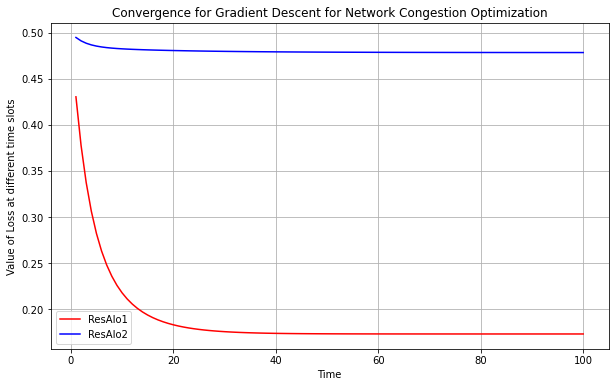

In [49]:
#Plotting the Scalar J vs. Number of Iterations for all X values combined
plt.plot(range(1, iterations + 1), result_1, color='Red', label = 'ResAlo1' )
plt.plot(range(1, iterations + 1), result_2, color='Blue', label = 'ResAlo2' )
plt.rcParams["figure.figsize"] = (10,6)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Value of Loss at different time slots')
plt.title('Convergence for Gradient Descent for Network Congestion Optimization')
plt.legend()
plt.show()